In [1]:
# Import some libraries
import numpy as np

from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import scienceplots

from classy import Class

import plotting_library as PL
from pylab import *
import MAS_library as MASL
import Pk_library as PKL

import vp_utils as utils

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    # Figure
    'figure.figsize': (6.8, 4.2),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,

    # Lines and markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Font
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,

    # Axes
    'axes.linewidth': 1.0,
    'axes.grid': False,
    'grid.alpha': 0.3,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,

    # Legend
    'legend.frameon': False,

    # Text rendering (LaTeX)
    'text.usetex': False,               # Optional: needs LaTeX installed
    'text.latex.preamble': r'\usepackage{amsmath,amssymb}',  # Optional
})

In [2]:
parameters_sim = utils.parameters_sim

In [3]:
# Load matter power spectrum previously computed with Pylians
kh_m = np.load('outputs/k_m.npy')
Pkh_m = np.load('outputs/Pk_m.npy')

h = parameters_sim['h']

k_m = kh_m*h   # convert to 1/Mpc
Pk_m = Pkh_m/h**3  # convert to (Mpc)^3

In [4]:
# Load power spectrum previously computed 

k_q = np.load('outputs/k_curl.npy')
Pk_omega = np.load('outputs/Pk_curl.npy')
Nmodes_omega = np.load('outputs/Nmodes_curl.npy')

Text(0, 0.5, '$\\Delta_\\text{B}(k)$')

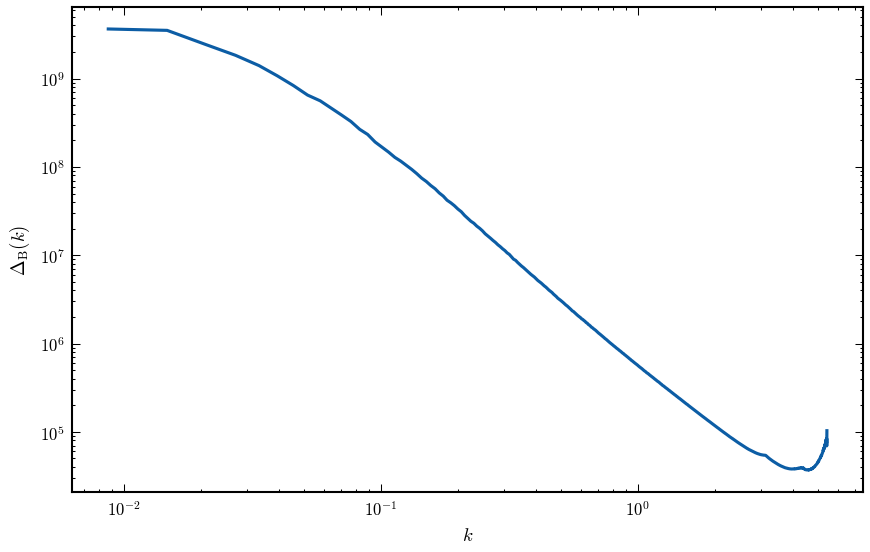

In [5]:
fig, ax = plt.subplots()

ax.loglog(k_q, Pk_omega/(k_q**3)/(2*np.pi**2))
# ax.loglog(k, Pk_curl/(k**3)/(2*np.pi**2))
ax.set_xlabel('$k$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')

In [6]:
Pk_matter_int = interp1d(np.log(k_m), np.log(Pk_m), kind='cubic')
Pk_omega_int = interp1d(np.log(k_q), np.log(Pk_omega), kind='cubic')

def Pk_matter_interp(k):
    return np.exp(Pk_matter_int(np.log(k)))

def Pk_omega_interp(k):
    return np.exp(Pk_omega_int(np.log(k)))

In [7]:
# Convert P_omega to P_q

def Pk_q(k):
    return Pk_omega_interp(k)/(k**2)

In [9]:
ell_grid = np.arange(int(1e2), int(1e4))

C_ells_XY = {}

C_ells_XY['PhiPhi'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['kSZ'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['BB'] = np.zeros_like(ell_grid, dtype=float)
C_ells_XY['B_X_kSZ'] = np.zeros_like(ell_grid, dtype=float)

for idx, ell in enumerate(ell_grid):


    C_ells_XY['PhiPhi'][idx] = utils.C_ell_Phi(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_matter_interp,
        Pk_evol=False,
    )

    C_ells_XY['kSZ'][idx] = utils.C_ell_kSZ(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=k_m[0],
        kmax=k_m[-1],
        Pk=Pk_matter_interp,
        Pk_evol=False,
    )

    C_ells_XY['BB'][idx] = utils.C_ell_B(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_q,
        Pk_evol=False,
    )

    C_ells_XY['B_X_kSZ'][idx] = utils.C_ell_B_X_kSZ(
        z_s=3,
        ell=ell,
        z_min=1e-5,
        kmin=k_q[0],
        kmax=k_q[-1],
        Pk=Pk_q,
        Pk_evol=False,
    )


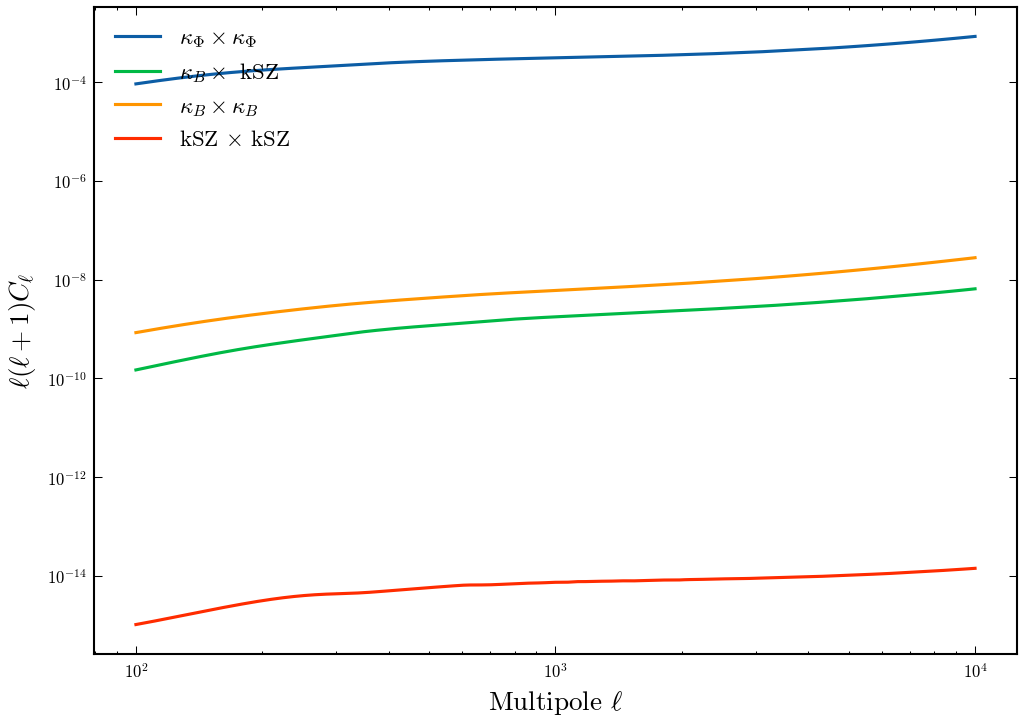

In [10]:
fig, ax = plt.subplots(figsize=(7, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['PhiPhi']      , label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['B_X_kSZ']     , label=r"$\kappa_B \times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['BB']          , label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['kSZ']         , label=r"kSZ $\times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
# ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.show()
